In [3]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [25]:
titles = open('title_list.txt').read().split('\n')
print(titles[:5])

['The Godfather', 'The Shawshank Redemption', "Schindler's List", 'Raging Bull', 'Casablanca']


In [26]:
links = open('link_list_imdb.txt').read().split('\n')
print(links[:5])

['http://www.imdb.com/title/tt0068646/', 'http://www.imdb.com/title/tt0111161/', 'http://www.imdb.com/title/tt0108052/', 'http://www.imdb.com/title/tt0081398/', 'http://www.imdb.com/title/tt0034583/']


In [27]:
synopses_wiki = open('synopses_list_wiki.txt',encoding='utf-8').read().split('\n BREAKS HERE')
print(synopses_wiki[:1])

[' Plot  [edit]  [  [  edit  edit  ]  ]  \n  On the day of his only daughter\'s wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito\'s youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito\'s godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter\'s wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito\'s youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito\'s godson

In [28]:
titles = titles[:100]
links = links[:100]
synopses_wiki= synopses_wiki[:100]
synopses_clean_wiki=[]
for text in synopses_wiki:
    text = BeautifulSoup(text,'html.parser').getText()
    synopses_clean_wiki.append(text)
synopses_wiki= synopses_clean_wiki

In [29]:
genres= open('genres_list.txt').read().split('\n')
print(genres[:5])

["[u' Crime', u' Drama']", "[u' Crime', u' Drama']", "[u' Biography', u' Drama', u' History']", "[u' Biography', u' Drama', u' Sport']", "[u' Drama', u' Romance', u' War']"]


In [30]:
genres = genres[:100]

In [32]:
print(str(len(titles))+'  titles')
print(str(len(links))+'  links')
print(str(len(synopses_wiki))+'  synopses_wiki')
print(str(len(genres))+'  genres')

100  titles
100  links
100  synopses_wiki
100  genres


In [33]:
synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [34]:
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [35]:
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)


In [36]:
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer#词干化
stemmer = SnowballStemmer("english")

In [39]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    #首先分句，接着分词，而也会作为词例存在
    filtered_tokens =[]
    #过滤掉所有不含字母的词例（例如：数字，纯标点）
    for token in tokens:
        if re.search('[a-zA-Z]',token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [40]:
def tokenize_only(text):
    # 首先分句，接着分词，而标点也会作为词例存在
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
   # 过滤所有不含字母的词例（例如：数字、纯标点）
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [41]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [43]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 312302 items in vocab_frame


In [44]:
print(vocab_frame.head())

     words
plot  plot
edit  edit
edit  edit
edit  edit
on      on


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

Wall time: 11.8 s
(100, 563)


In [46]:
terms = tfidf_vectorizer.get_feature_names()
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print(dist)

[[ -4.44089210e-16   8.00539634e-01   7.62813109e-01 ...,   6.41312416e-01
    6.70578229e-01   8.23926244e-01]
 [  8.00539634e-01  -2.22044605e-16   7.33477850e-01 ...,   7.33117814e-01
    7.71609239e-01   8.92974798e-01]
 [  7.62813109e-01   7.33477850e-01  -4.44089210e-16 ...,   7.23806699e-01
    7.49489708e-01   8.58673233e-01]
 ..., 
 [  6.41312416e-01   7.33117814e-01   7.23806699e-01 ...,  -4.44089210e-16
    4.50879024e-01   9.17464687e-01]
 [  6.70578229e-01   7.71609239e-01   7.49489708e-01 ...,   4.50879024e-01
   -2.22044605e-16   8.68599864e-01]
 [  8.23926244e-01   8.92974798e-01   8.58673233e-01 ...,   9.17464687e-01
    8.68599864e-01  -2.22044605e-16]]


In [47]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 1.06 s


In [48]:
from sklearn.externals import joblib
 
# 注释语句用来存储你的模型
# 因为我已经从 pickle 载入过模型了
 
#joblib.dump(km,  'doc_cluster.pkl')
 
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

c:\users\lulinlin\appdata\local\programs\python\python35\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator KMeans from version pre-0.18 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\lulinlin\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The file 'doc_cluster.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  


In [49]:
import pandas as pd

films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [50]:
print(frame)

    rank                                              title  cluster  \
2      0                                      The Godfather        2   
4      1                           The Shawshank Redemption        4   
0      2                                   Schindler's List        0   
2      3                                        Raging Bull        2   
1      4                                         Casablanca        1   
0      5                    One Flew Over the Cuckoo's Nest        0   
0      6                                 Gone with the Wind        0   
2      7                                       Citizen Kane        2   
0      8                                   The Wizard of Oz        0   
0      9                                            Titanic        0   
4     10                                 Lawrence of Arabia        4   
2     11                             The Godfather: Part II        2   
1     12                                             Psycho     

In [51]:
grouped = frame['rank'].groupby(frame['cluster']) 

In [52]:
grouped.mean() 

cluster
0    47.200000
1    58.875000
2    49.380952
3    54.500000
4    43.730769
Name: rank, dtype: float64

In [56]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'family', b'home', b'mother', b'war', b'house', b'dies',

Cluster 0 titles: Schindler's List, One Flew Over the Cuckoo's Nest, Gone with the Wind, The Wizard of Oz, Titanic, Forrest Gump, E.T. the Extra-Terrestrial, The Silence of the Lambs, Gandhi, A Streetcar Named Desire, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, The Pianist, The Exorcist, Out of Africa, Good Will Hunting, Terms of Endearment, Giant, The Grapes of Wrath, Close Encounters of the Third Kind, The Graduate, Stagecoach, Wuthering Heights,

Cluster 1 words: b'police', b'car', b'killed', b'murders', b'driving', b'house',

Cluster 1 titles: Casablanca, Psycho, Sunset Blvd., Vertigo, Chinatown, Amadeus, High Noon, The French Connection, Fargo, Pulp Fiction, The Maltese Falcon, A Clockwork Orange, Double Indemnity, Rebel Without a Cause, The Third Man, North by Northwest,

Cluster 2 words: b'father', b'new', b'york', b'new', b'brothers', b'apartments',

Clust

In [57]:
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']
print(frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Rank</th>
      <th>Title</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>5</td>
      <td>Casablanca</td>
    </tr>
    <tr>
      <td>13</td>
      <td>Psycho</td>
    </tr>
    <tr>
      <td>14</td>
      <td>Sunset Blvd.</td>
    </tr>
    <tr>
      <td>15</td>
      <td>Vertigo</td>
    </tr>
    <tr>
      <td>24</td>
      <td>Chinatown</td>
    </tr>
    <tr>
      <td>31</td>
      <td>Amadeus</td>
    </tr>
    <tr>
      <td>57</td>
      <td>High Noon</td>
    </tr>
    <tr>
      <td>64</td>
      <td>The French Connection</td>
    </tr>
    <tr>
      <td>77</td>
      <td>Fargo</td>
    </tr>
    <tr>
      <td>87</td>
      <td>Pulp Fiction</td>
    </tr>
    <tr>
      <td>91</td>
      <td>The Maltese Falcon</td>
    </tr>
    <tr>
      <td>92</td>
      <td>A Clockwork Orange</td>
    </tr>
    <tr>
      <td>95</td>
      <td>Double Indemnity</td>
    </tr>
    <tr

In [58]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [59]:
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [60]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

c:\users\lulinlin\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


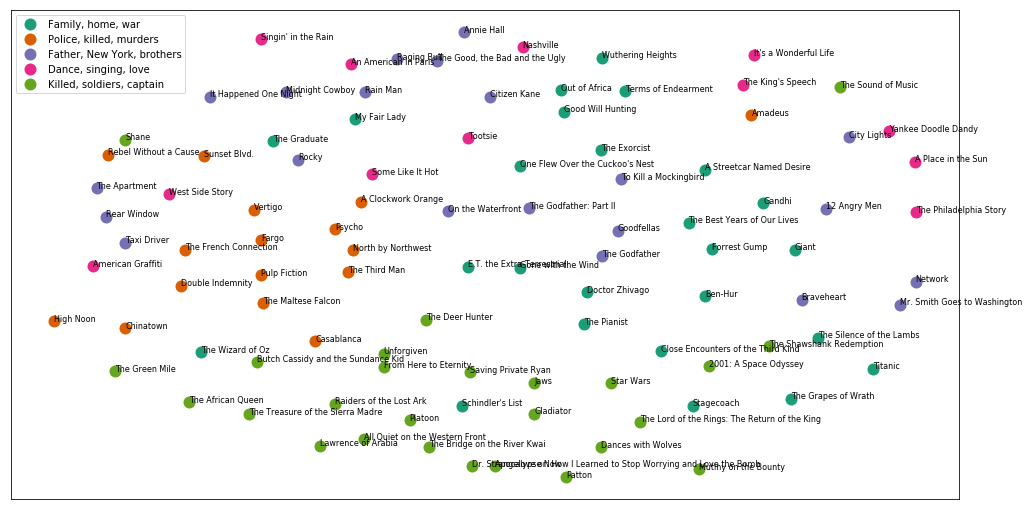

In [63]:
%matplotlib inline
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [64]:
plt.close()